# Comparison to Other QSP Methods

<span style="color:red;"> Note: the current comparisons are only done on dense states (i.e., $N = 2^n$). Sparse states (i.e., $N < 2^n$) are not tested. The differences on sparse state might be even larger. </span>

In this notebook, we provide comparison of the execution time for quantum state preparation task using:

1. Our newly implemented QSP method `qsp_qubit_eff` using the multi-control Ry gate sequences via Braket

2. Qiskit's build-in `.initialize` method

3. Braket's `.unitary` method

## Result Summary

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

The plot below shows the `CPU time` for each QSP method across different size $n$ (real amplitude only).

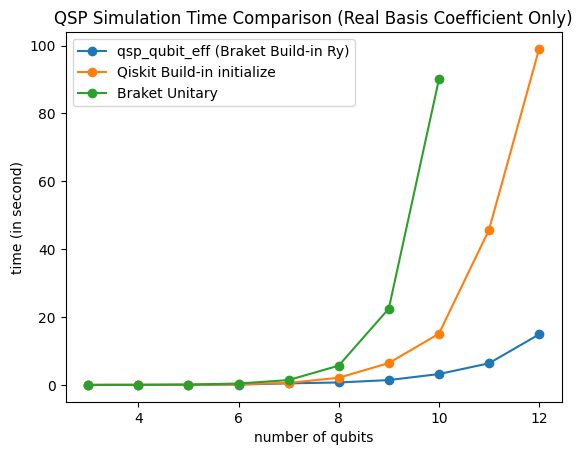

In [2]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
n = 12
braket_time_array = [0.0203, 0.0292, 0.0635, 0.121, 0.484, 0.739, 1.45, 3.22, 6.39, 14.9]
qiskit_time_array = [0.0246, 0.0528, 0.0911, 0.204, 0.605, 2.13, 6.47, 15.1, 45.7, 99]
braket_unitary_time_array = [0.0257, 0.0429, 0.114, 0.427, 1.45, 5.70, 22.5, 90]
x1 = range(3, n + 1)
x2 = range(3, n - 2 + 1)
ax.plot(x1, braket_time_array, label='qsp_qubit_eff (Braket Build-in Ry)', marker='o')  # Plot some data on the axes.
ax.plot(x1, qiskit_time_array, label='Qiskit Build-in initialize', marker='o')  # Plot some data on the axes.
ax.plot(x2, braket_unitary_time_array, label='Braket Unitary', marker='o')  # Plot some data on the axes.
ax.set_xlabel('number of qubits')  # Add an x-label to the axes.
ax.set_ylabel('time (in second)')  # Add a y-label to the axes.
ax.set_title("QSP Simulation Time Comparison (Real Basis Coefficient Only)")  # Add a title to the axes.
ax.legend()  # Add a legend.

(Note that the Braket Unitary time for n = 11 and n = 12 is not report due to their longer time)

The plot below shows the `CPU time` for each QSP method across different size $n$ (with complex basis coefficient).

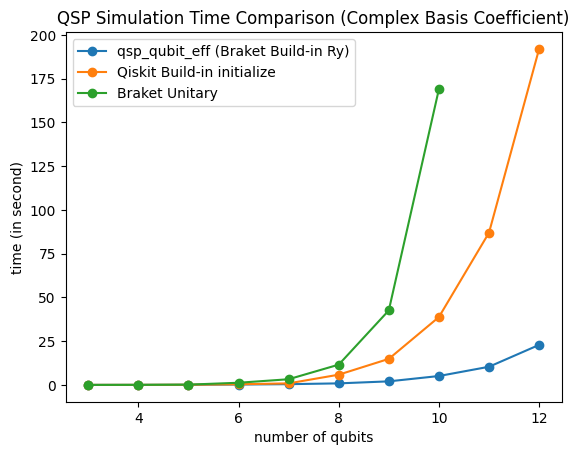

In [3]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
n = 12
braket_time_array = [0.0229, 0.0429, 0.0868, 0.253, 0.451, 0.907, 2.06, 5.11, 10.4, 22.9]
qiskit_time_array = [0.0371, 0.0593, 0.132, 0.381, 0.910, 5.87, 14.9, 38.8, 87, 192]
braket_unitary_time_array = [0.028, 0.062, 0.186, 1.26, 3.27, 11.6, 42.6, 169]
x1 = range(3, n + 1)
x2 = range(3, n - 2 + 1)
ax.plot(x1, braket_time_array, label='qsp_qubit_eff (Braket Build-in Ry)', marker='o')  # Plot some data on the axes.
ax.plot(x1, qiskit_time_array, label='Qiskit Build-in initialize', marker='o')  # Plot some data on the axes.
ax.plot(x2, braket_unitary_time_array, label='Braket Unitary', marker='o')  # Plot some data on the axes.
ax.set_xlabel('number of qubits')  # Add an x-label to the axes.
ax.set_ylabel('time (in second)')  # Add a y-label to the axes.
ax.set_title("QSP Simulation Time Comparison (Complex Basis Coefficient)")  # Add a title to the axes.
ax.legend()  # Add a legend.

(Note that the Braket Unitary time for n = 11 and n = 12 is not report due to their longer time)

<span style="color:orange;"> Note: the actual CPU time for each data point will have slight variations. </span>

In [4]:
import numpy as np
import random
import math

from helper_functions import round_to_three_significant_digits, row_to_column_vector, generate_normalized_real_array, generate_normalized_complex_array

## Generate target wave function vector array

In [8]:
%%time
np.random.seed(10) # fix a seed for data reproduction purpose, you can change this value to play with other results
n = 3 # number of qubits. We can encode 2^n number of values with n qubits!
normalized_complex_array = generate_normalized_complex_array(n) # change this line to generate_normalized_real_array(n) to test on real amplitude only
print(row_to_column_vector(round_to_three_significant_digits(normalized_complex_array, 3)))

[[ 0.222-0.271j]
 [-0.392-0.337j]
 [ 0.109+0.152j]
 [ 0.204+0.371j]
 [-0.001-0.406j]
 [-0.225+0.01j ]
 [-0.247+0.256j]
 [ 0.213+0.092j]]
CPU times: user 946 µs, sys: 172 µs, total: 1.12 ms
Wall time: 1.09 ms


## Experiment 1: Braket QSP Timer

In [7]:
# Import Braket libraries
import braket
from braket.circuits import Circuit
from braket.aws import AwsDevice
from braket.devices import LocalSimulator
braket_device = LocalSimulator() # define the simulator

from qsp_circ_construction_qubit_efficient import qsp_qubit_eff

In [9]:
%%time
braket_qsp_circ = qsp_qubit_eff(normalized_complex_array)

CPU times: user 3.48 ms, sys: 460 µs, total: 3.94 ms
Wall time: 3.58 ms


In [10]:
%%time
braket_qsp_circ.state_vector() # convert the circuit to state vector
braket_result = braket_device.run(braket_qsp_circ, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_result, 3))) # print out the resulted state vector

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[ 0.109-0.333j]
 [-0.488-0.172j]
 [ 0.157+0.102j]
 [ 0.324+0.272j]
 [-0.148-0.378j]
 [-0.206+0.091j]
 [-0.137+0.328j]
 [ 0.232+0.008j]]
CPU times: user 87.6 ms, sys: 4.86 ms, total: 92.5 ms
Wall time: 91.7 ms


(Note that the result is differed by a global phase)

## Experiment 2: Qiskit QSP Timer

In [6]:
# Import Qiskit libraries
from qiskit import QuantumCircuit
from qiskit.execute_function import execute
from qiskit import BasicAer
from qiskit import transpile

### Qiskit State Vector Simulator

In [11]:
qiskit_circ = QuantumCircuit(n)
qiskit_circ.initialize(normalized_complex_array, range(n))
# print(qiskit_circ)

In [12]:
%%time
qiskit_backend = BasicAer.get_backend('statevector_simulator')
job = execute(qiskit_circ, qiskit_backend)
qiskit_state_vector_result = job.result().get_statevector()
print(row_to_column_vector(round_to_three_significant_digits(qiskit_state_vector_result, 3))) # print out the resulted state vector

[[ 0.222-0.271j]
 [-0.392-0.337j]
 [ 0.109+0.152j]
 [ 0.204+0.371j]
 [-0.001-0.406j]
 [-0.225+0.01j ]
 [-0.247+0.256j]
 [ 0.213+0.092j]]
CPU times: user 79.3 ms, sys: 25.5 ms, total: 105 ms
Wall time: 128 ms


### Qiskit QASM Simulator

We also tested the QASM simulator. The consumed time is very similar to the state vector simulation. Therefore, we only report the time result for the state vector simlulator below.

In [13]:
%%time
circ = QuantumCircuit(n)
circ.initialize(normalized_complex_array, range(n))

circ.measure_all()

# Transpile for simulator
simulator = BasicAer.get_backend('qasm_simulator')
circ = transpile(circ, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
# plot_histogram(counts, title='Bell-State counts')

CPU times: user 58.1 ms, sys: 2.72 ms, total: 60.8 ms
Wall time: 59.6 ms


## Experiment 3: Braket Unitary QSP Timer

We can use the `.to_unitary` method on the constructed QSP circuit to get the unitary operator matrix, which can be used for the `.unitary` method to construct the QSP circuit using the unitary. (Note: there might be a more efficient way to get the unitary matrix, the point of this experiment is only to examine the runtime for the `.unitary` method.

In [14]:
%%time
braket_qsp_circ_unitary_matrix_alt = braket_qsp_circ.to_unitary()
braket_qsp_circ_from_unitary_alt = Circuit()

CPU times: user 3.42 ms, sys: 1.57 ms, total: 4.99 ms
Wall time: 3.59 ms


In [15]:
%%time
braket_qsp_circ_from_unitary_alt.unitary(matrix=braket_qsp_circ_unitary_matrix_alt, targets=range(n))
braket_qsp_circ_from_unitary_alt.state_vector() # convert the circuit to state vector
braket_result_from_unitary_alt = braket_device.run(braket_qsp_circ_from_unitary_alt, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_result_from_unitary_alt, 3))) # print out the resulted state vector

[[ 0.008-0.004j]
 [ 0.047+0.268j]
 [-0.024-0.002j]
 [ 0.29 -0.667j]
 [ 0.005+0.006j]
 [-0.207+0.076j]
 [-0.002-0.02j ]
 [ 0.573+0.135j]]
CPU times: user 63.9 ms, sys: 1.75 ms, total: 65.7 ms
Wall time: 65.5 ms


(Note that the result is differed by a global phase)

What if some ask, wait isn't this just because Braket in innately better than Qiskit for general quantum circuit simulations?

The purpose of the following two experiment is to show that the Qiskit simulator runs faster than the Braket simulator for general low-depth and high-qubit-count circuits.

## Experiment 4: Braket vs Qiskit: GHZ State (high Qubit Count) Construction

We create 24-qubit states and compare the performance using Braket and Qiskit simulators.

In [16]:
n = 24
qiskit_ghz_circ = QuantumCircuit(n)
qiskit_ghz_circ.h(0)
for i in range(n - 1):
    qiskit_ghz_circ.cx(i, i + 1)
# print(qiskit_ghz_circ)

In [17]:
%%time
job = execute(qiskit_ghz_circ, qiskit_backend)
qiskit_state_vector_result = job.result().get_statevector()
print(row_to_column_vector(round_to_three_significant_digits(qiskit_state_vector_result, 3))) # print out the resulted state vector

[[0.707+0.j]
 [0.   +0.j]
 [0.   +0.j]
 ...
 [0.   +0.j]
 [0.   +0.j]
 [0.707+0.j]]
CPU times: user 14.4 s, sys: 2.49 s, total: 16.9 s
Wall time: 17.1 s


In [18]:
braket_ghz_circ = Circuit()
braket_ghz_circ.h(0)
for i in range(n - 1):
    braket_ghz_circ.cnot(i, i + 1)
# print(braket_ghz_circ)

In [19]:
%%time
braket_ghz_circ.state_vector() # convert the circuit to state vector
braket_result = braket_device.run(braket_ghz_circ, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_result, 3))) # print out the resulted state vector

[[0.707+0.j]
 [0.   +0.j]
 [0.   +0.j]
 ...
 [0.   +0.j]
 [0.   +0.j]
 [0.707+0.j]]
CPU times: user 38.1 s, sys: 5.46 s, total: 43.6 s
Wall time: 16.4 s


## Experiment 5: Braket vs Qiskit: High Depth Circuit Construction

The purpose of this experiment is to show that the Qiskit simulator runs faster than the Braket simulator for general high-depth and low-qubit-count circuits.

We repeat the following circuit for many layers, each layers with randomized Rx and Rz angles:

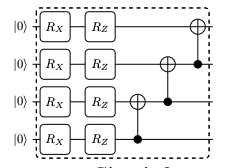

In [20]:
def generate_random_2d_array(x, y):
    # Create a list comprehension to generate rows, where each row contains 'y' random numbers between -π and π
    return [[random.uniform(-math.pi, math.pi) for _ in range(y)] for _ in range(x)]

In [21]:
layer = 3000
n = 4
rx_angles_2d_array = generate_random_2d_array(layer, n)
rz_angles_2d_array = generate_random_2d_array(layer, n)
# print(rx_angles_2d_array)

In [22]:
qiskit_high_depth_circ = QuantumCircuit(n)
for i in range(layer):
    for j in range(n):
        qiskit_high_depth_circ.rx(rx_angles_2d_array[i][j], j)
    for j in range(n):
        qiskit_high_depth_circ.rz(rz_angles_2d_array[i][j], j)
    for k in range(n - 1):
        qiskit_high_depth_circ.cx(k, k + 1)

# print(qiskit_high_depth_circ)

In [23]:
%%time
job = execute(qiskit_high_depth_circ, qiskit_backend)
qiskit_state_vector_result = job.result().get_statevector()
print(row_to_column_vector(round_to_three_significant_digits(qiskit_state_vector_result, 3))) # print out the resulted state vector

[[-0.304+0.28j ]
 [-0.042+0.17j ]
 [ 0.144+0.158j]
 [-0.315-0.215j]
 [-0.162+0.015j]
 [-0.013+0.088j]
 [-0.069+0.191j]
 [ 0.152+0.078j]
 [ 0.176-0.416j]
 [-0.144+0.157j]
 [ 0.14 -0.045j]
 [ 0.246-0.097j]
 [ 0.213+0.153j]
 [ 0.171-0.073j]
 [-0.179+0.021j]
 [ 0.139-0.082j]]
CPU times: user 5.7 s, sys: 94.5 ms, total: 5.79 s
Wall time: 5.82 s


In [24]:
braket_high_depth_circ = Circuit()
for i in range(layer):
    for j in range(n):
        braket_high_depth_circ.rx(j, rx_angles_2d_array[i][j])
    for j in range(n):
        braket_high_depth_circ.rz(j, rz_angles_2d_array[i][j])
    for k in range(n - 1):
        braket_high_depth_circ.cnot(k, k + 1)

# print(braket_high_depth_circ)

In [25]:
%%time
braket_high_depth_circ.state_vector() # convert the circuit to state vector
braket_result = braket_device.run(braket_high_depth_circ, shots=0).result().values[0] # extract the result
print(row_to_column_vector(round_to_three_significant_digits(braket_result, 3))) # print out the resulted state vector

[[-0.304+0.28j ]
 [ 0.176-0.416j]
 [-0.162+0.015j]
 [ 0.213+0.153j]
 [ 0.144+0.158j]
 [ 0.14 -0.045j]
 [-0.069+0.191j]
 [-0.179+0.021j]
 [-0.042+0.17j ]
 [-0.144+0.157j]
 [-0.013+0.088j]
 [ 0.171-0.073j]
 [-0.315-0.215j]
 [ 0.246-0.097j]
 [ 0.152+0.078j]
 [ 0.139-0.082j]]
CPU times: user 23.5 s, sys: 244 ms, total: 23.7 s
Wall time: 23.9 s


In [25]:
import braket._sdk as braket_sdk
braket_sdk.__version__

'1.55.0'

In [26]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.25.1', 'qiskit': '0.44.1', 'qiskit-aer': '0.12.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [27]:
import sys
print(sys.version)

3.10.11 (main, May 17 2023, 14:30:36) [Clang 14.0.6 ]
